In [ ]:
# PCenter 扩展：可选传入 distance_matrix（用于路网最短路距离）
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum
from hispot.FLP.BaseLocate import PModel

class PCenterCustom(PModel):
    def __init__(self, num_points, points, solver, num_located, distance_matrix=None):
        super().__init__(num_points, points, solver, num_located)
        self.distance = distance_matrix  # 若为 None，则回退到欧氏距离
        self.x = None
        self.y = None
        self.name = 'p-center'

    def prob_solve(self):
        # 若未提供矩阵，按欧氏距离计算（与原库一致）
        if self.distance is None:
            self.distance = np.linalg.norm(
                self.points[:, None, :] - self.points[None, :, :], axis=2
            )

        # 距离矩阵校验与不可达处理
        N = self.num_points
        if self.distance.shape != (N, N):
            raise ValueError(f"distance_matrix 形状应为 {(N, N)}，当前为 {self.distance.shape}")
        is_finite = np.isfinite(self.distance)
        # 确保自距离为 0（若传入矩阵未置零）
        for i in range(N):
            if not np.isfinite(self.distance[i, i]):
                self.distance[i, i] = 0.0
                is_finite[i, i] = True

        # 构建 p-center 模型：最小化最大服务距离 Z
        prob = LpProblem("p-Center_Problem", LpMinimize)
        Zones = list(range(N))
        x = LpVariable.dicts("Select", Zones, cat="Binary")           # 设施是否选址
        y = LpVariable.dicts("Assign", (Zones, Zones), cat="Binary")  # 需求是否分配给设施
        Z = LpVariable("max_Distance", lowBound=0)
        self.x, self.y = x, y

        prob += Z
        prob += (lpSum(x[i] for i in range(N)) == self.num_located)

        for i in range(N):
            reachable_js = [j for j in range(N) if is_finite[i, j]]
            if not reachable_js:
                raise ValueError(f"点 {i} 对任何设施都不可达（distance_matrix 第 {i} 行全为 inf/NaN）")
            # 仅在可达设施中完成一次分配
            prob += (lpSum(y[i][j] for j in reachable_js) == 1)
            # 不可达对强制为 0，避免在约束中出现 inf 系数
            for j in range(N):
                if not is_finite[i, j]:
                    prob += (y[i][j] == 0)
            # 分配-选址一致性（仅对可达对设置）
            for j in reachable_js:
                prob += y[i][j] <= x[j]
            # 最大距离约束仅在可达对上累加
            prob += lpSum(y[i][j] * float(self.distance[i, j]) for j in reachable_js) <= Z

        return self.show_result(prob)

# 关键：把 Notebook 里的 PCenter 名称指向扩展后的类，原有调用可直接复用
PCenter = PCenterCustom

In [ ]:
# 路网 -> 图 -> 距离矩阵与路径生成
# 依赖：geopandas, shapely>=2.0, networkx, momepy(可选)
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString
import networkx as nx
import numpy as np
from typing import Tuple, Dict, List

# -------- 工具：投影到米制 --------
def to_metric_gdf(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf.crs is None:
        raise ValueError("路网缺少 CRS，请在 read_clean_roads(..., assumed_crs=...) 指定或给 shapefile 提供 .prj")
    if gdf.empty or gdf.geometry.is_empty.all():
        raise ValueError("路网几何为空，检查数据或清洗流程")
    crs_obj = gdf.crs
    if getattr(crs_obj, "is_geographic", False):
        metric_crs = gdf.estimate_utm_crs()
        return gdf.to_crs(metric_crs)
    else:
        # 已是投影坐标（米），直接返回
        return gdf

# -------- 工具：读取并清洗路网 --------
def read_clean_roads(roads_path: str, assumed_crs=None) -> gpd.GeoDataFrame:
    roads = gpd.read_file(roads_path)
    # 若缺 CRS，允许外部指定
    if roads.crs is None and assumed_crs is not None:
        roads = roads.set_crs(assumed_crs)
    # 只保留 LineString/MultiLineString
    roads = roads[roads.geometry.type.isin(["LineString", "MultiLineString"])].copy()
    # explode MultiLineString
    roads = roads.explode(index_parts=False).reset_index(drop=True)
    roads = roads[roads.geometry.notnull()].copy()
    # 不再对线做 buffer(0)，避免空几何
    roads = to_metric_gdf(roads)
    # 去除零长度或无效
    roads = roads[roads.length > 0]
    roads = roads[~roads.geometry.is_empty]
    return roads

# -------- 建图：仅端点为节点（快速法） --------
def build_graph_from_lines(roads: gpd.GeoDataFrame, directed: bool=False) -> nx.Graph:
    G = nx.DiGraph() if directed else nx.Graph()
    for geom in roads.geometry:
        if isinstance(geom, LineString):
            coords = list(geom.coords)
            for u, v in zip(coords[:-1], coords[1:]):
                length = float(LineString([u, v]).length)
                if directed:
                    G.add_edge(u, v, weight=length, geometry=LineString([u, v]))
                else:
                    G.add_edge(u, v, weight=length, geometry=LineString([u, v]))
        else:
            # 非 LineString（如 MultiLine 已 explode），此处忽略
            pass
    return G

# -------- 点吸附：到最近边并插入节点（精确法） --------
from shapely.ops import nearest_points

def snap_point_to_graph(point_xy: Tuple[float, float], roads: gpd.GeoDataFrame, G: nx.Graph,
                        max_search=5_000) -> Tuple[Tuple[float, float], List[Tuple[float, float]]]:
    p = Point(point_xy)
    # 限定检索范围以提速
    bbox = p.buffer(max_search)
    candidates = roads[roads.intersects(bbox)]
    if candidates.empty:
        # 回退：全表最近
        idx = roads.distance(p).idxmin()
        line = roads.loc[idx, 'geometry']
    else:
        idx = candidates.distance(p).idxmin()
        line = candidates.loc[idx, 'geometry']

    # 在线上找到投影点
    proj_dist = line.project(p)
    snapped = line.interpolate(proj_dist)

    # 把该线分割成两段，向图中插入 snapped 作为新节点
    coords = list(line.coords)
    # 沿线累计寻找插入位置
    acc = 0.0
    inserted_edges = []
    prev = coords[0]
    for nxt in coords[1:]:
        seg = LineString([prev, nxt])
        seg_len = seg.length
        if acc + seg_len >= proj_dist - 1e-8:
            # 插入位置在本段
            # 先移除原边
            if G.has_edge(prev, nxt):
                G.remove_edge(prev, nxt)
            # 加两段
            sp = (snapped.x, snapped.y)
            G.add_edge(prev, sp, weight=LineString([prev, sp]).length, geometry=LineString([prev, sp]))
            G.add_edge(sp, nxt, weight=LineString([sp, nxt]).length, geometry=LineString([sp, nxt]))
            inserted_edges.extend([(prev, sp), (sp, nxt)])
            break
        acc += seg_len
        prev = nxt
    return (snapped.x, snapped.y), inserted_edges

# -------- 最短路与路径几何 --------

def shortest_path_and_length(G: nx.Graph, s: Tuple[float,float], t: Tuple[float,float]):
    path = nx.shortest_path(G, s, t, weight='weight')
    # 拼接几何
    lines = []
    length = 0.0
    for u, v in zip(path[:-1], path[1:]):
        data = G.get_edge_data(u, v)
        geom = data.get('geometry', LineString([u, v]))
        lines.append(geom)
        length += data.get('weight', geom.length)
    return length, shapely.line_merge(shapely.geometry.MultiLineString(lines)), path

# -------- 批量生成矩阵与路径 --------

def network_distance_matrix(points_xy: np.ndarray, roads_path: str,
                            directed: bool=False, return_paths: bool=True,
                            roads_assumed_crs=None, points_crs=None):
    # 1) 读路网并建图
    roads = read_clean_roads(roads_path, assumed_crs=roads_assumed_crs)
    G = build_graph_from_lines(roads, directed=directed)

    # 1.5) 如果点是经纬度或其他CRS，投影到与路网一致的米制CRS
    if points_crs is not None:
        gdf_pts = gpd.GeoDataFrame(geometry=[Point(xy) for xy in points_xy], crs=points_crs)
        gdf_pts = gdf_pts.to_crs(roads.crs)
        points_xy = np.array([[pt.x, pt.y] for pt in gdf_pts.geometry])

    # 2) 吸附所有点到图（插入节点）
    snapped_nodes = []
    for xy in points_xy:
        sp, _ = snap_point_to_graph(tuple(xy), roads, G)
        snapped_nodes.append(sp)

    snapped_nodes = [tuple(xy) for xy in snapped_nodes]
    n = len(snapped_nodes)
    D = np.zeros((n, n), dtype=float)
    paths_geom = [[None]*n for _ in range(n)] if return_paths else None

    # 3) 逐对最短路
    for i in range(n):
        for j in range(n):
            if i == j:
                D[i, j] = 0.0
                if return_paths:
                    paths_geom[i][j] = LineString([snapped_nodes[i], snapped_nodes[j]])
                continue
            try:
                d, geom, _ = shortest_path_and_length(G, snapped_nodes[i], snapped_nodes[j])
            except nx.NetworkXNoPath:
                d, geom = np.inf, None
            D[i, j] = d
            if return_paths:
                paths_geom[i][j] = geom
    return D, paths_geom, snapped_nodes, G

In [ ]:
# 示例：生成路网距离矩阵并用于 p-center（保持与原 Notebook 用法一致）
# 请确认安装：geopandas, shapely>=2.0, networkx

# 1) 准备点坐标（建议已是米制投影坐标，否则先投影）
# 若你的 points_np 为经纬度，请先使用 GeoPandas 投影到米制。

roads_path = r"D:\Academic\Task123_HiSpot\hispot-main\data\guangzhou\南沙区路网.shp"

# points_np 已存在于 Notebook；若为 lon-lat，请先转米制后再传入 network_distance_matrix
D_net, paths_geom, snapped_nodes, G = network_distance_matrix(
    points_np,
    roads_path,
    directed=False,
    return_paths=True,
    points_crs="EPSG:4326"  # 路网和点都是WGS84
)

# 2) 接入扩展后的 PCenter（传入 distance_matrix）
from pulp import PULP_CBC_CMD
centers, assigns, obj = PCenter(
    num_points=points_np.shape[0],
    points=points_np,              # 仅用于可视化坐标（不再使用欧氏距离）
    solver=PULP_CBC_CMD(),
    num_located=num_located,
    distance_matrix=D_net          # 核心：使用路网最短路距离矩阵
).prob_solve()

print("Centers:", centers)
print("Objective (max network distance):", obj)

Status: Optimal
Centers = [3, 28, 45, 46, 51]
Assigned relationships =  {3: [4, 5, 6, 7, 8, 9, 10, 11], 28: [0, 29, 30, 31, 32, 33], 45: [43], 46: [23, 25, 26, 27, 39, 40, 47], 51: [1, 2, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 34, 35, 36, 37, 38, 41, 42, 44, 48, 49, 50, 52, 53]}
Minimum Maximum distance =  17015.97
Centers: [3, 28, 45, 46, 51]
Objective (max network distance): 17015.97


In [67]:
# 可视化：按中心-分配对绘制路网路径（不同 center 不同颜色）
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


def plot_assign_paths(points_np, centers, assigns, paths_geom, snapped_nodes=None, roads_gdf=None,
                      title=None, colors=None, cmap='Dark2', linewidth=2.5, alpha=0.9,
                      color_demands_by_center=False):
    fig, ax = plt.subplots(figsize=(8, 8))
    if roads_gdf is not None:
        roads_gdf.plot(ax=ax, color="#B0B0B0", linewidth=0.6, alpha=0.7)

    # 颜色映射：每个 center 一个颜色（默认使用不含灰的 Set1 调色板）
    if colors is None:
        cmap_obj = plt.get_cmap(cmap, max(1, len(centers)))
        colors = [cmap_obj(i) for i in range(len(centers))]
        # 过滤灰色（若存在），简单规则：r,g,b 三通道差值都很小且接近中间值
        def is_gray(c):
            r, g, b = c[:3]
            return (abs(r-g) < 0.03 and abs(r-b) < 0.03 and abs(g-b) < 0.03 and 0.3 < r < 0.8)
        colors = [c for c in colors if not is_gray(c)] or colors

    # 绘制路径（按中心着色），不进入图例
    for idx, ci in enumerate(centers):
        color_i = colors[idx % len(colors)]
        segs = []
        js = assigns.get(ci, [])
        for dj in js:
            geom = paths_geom[dj][ci]
            if geom is not None:
                if hasattr(geom, 'geoms'):
                    for g in geom.geoms:
                        segs.append(np.array(g.coords))
                else:
                    segs.append(np.array(geom.coords))
        if segs:
            lc = LineCollection(segs, colors=[color_i], linewidths=linewidth, alpha=alpha, zorder=10)
            ax.add_collection(lc)

    # 需求点（按中心着色，统一白色描边，圆形）
    if color_demands_by_center:
        painted = set()
        for idx, ci in enumerate(centers):
            color_i = colors[idx % len(colors)]
            js = assigns.get(ci, [])
            group = js + [ci]
            group = [k for k in group if 0 <= k < len(points_np)]
            if not group:
                continue
            ax.scatter(points_np[group, 0], points_np[group, 1], c=[color_i], s=20,
                       edgecolors='k', linewidths=0.9, zorder=20)
            painted.update(group)
        rest = [k for k in range(len(points_np)) if k not in painted]
        if rest:
            ax.scatter(points_np[rest, 0], points_np[rest, 1], c='#9ecae1', s=18,
                       edgecolors='k', linewidths=0.8, zorder=19)
    else:
        ax.scatter(points_np[:, 0], points_np[:, 1], c='tab:blue', s=20,
                   edgecolors='k', linewidths=0.8, zorder=20)

    # 中心点（星形，统一黑色描边）
    for idx, ci in enumerate(centers):
        color_i = colors[idx % len(colors)]
        ax.scatter(points_np[ci, 0], points_np[ci, 1], c=[color_i], s=80, marker='*',
                   edgecolors='k', linewidths=0.6, zorder=30)

    # 自定义图例：仅展示形状（不标注各 center 的颜色）
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0], [0], marker='o', color='none', markerfacecolor='#9ecae1',
               markeredgecolor='k', markeredgewidth=1.0, markersize=7, label='Facilities'),
        Line2D([0], [0], marker='*', color='none', markerfacecolor='#ffcc00',
               markeredgecolor='k', markeredgewidth=0.7, markersize=10, label='Centers'),
    ]
    ax.legend(handles=handles, frameon=False, loc='best')

    # 不显示标题
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    return fig, ax

# 使用示例
# roads_gdf = read_clean_roads(roads_path)
# plot_assign_paths(points_np, centers, assigns, paths_geom, roads_gdf=roads_gdf,
#                   title='pCenter with network distances', color_demands_by_center=False)

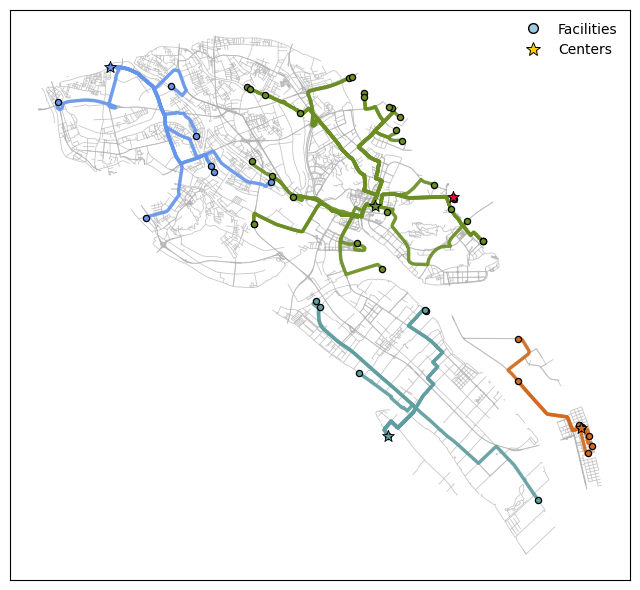

In [68]:
%matplotlib inline
roads_gdf = read_clean_roads(roads_path, assumed_crs="EPSG:4326")  # 若路网缺CRS且是WGS84
my_colors = [
    '#D2691E', '#5F9EA0', '#DC143C', '#6495ED', '#6B8E23','#8B008B',  # 5 个主色
    '#FFD700', '#DAA520', '#ADD8E6', '#20B2AA', '#9370D8', '#6B8E23', '#DDA0DD', '#2E8B57'  # 备用
]
fig, ax = plot_assign_paths(
    points_np=np.array(snapped_nodes),  # 或者用投影后的点
    centers=centers,
    assigns=assigns,
    paths_geom=paths_geom,
    roads_gdf=roads_gdf,
    title="pCenter with network distances",
    colors=my_colors,
    color_demands_by_center=True  # True: 不同center的需求点也跟随着色
)

In [69]:
# 保存上一单元返回的图为 300 dpi
import matplotlib.pyplot as plt
fig.savefig("pCenter-nansha-paths.png", dpi=300, bbox_inches="tight")
plt.show()


# p-Center Problem
The p-center problem, as a traditional discrete location selection problem, has been applied widely in logistics, emergency facility location selection, and other fields.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Description" data-toc-modified-id="Problem-Description-1">Problem Description</a></span><ul class="toc-item"><li><span><a href="#p-Center" data-toc-modified-id="p-Center-1.1">p-Center</a></span></li><li><span><a href="#Integer-programming-model:" data-toc-modified-id="Integer-programming-model:-1.2">Integer programming model:</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-3">Examples</a></span><ul class="toc-item"><li><span><a href="#Case1.-Solving-p-Median-problem-with-synthetic-data" data-toc-modified-id="Case1.-Solving p-Median problem with synthetic data-3.1"> Case1. Solving p-Center problem with synthetic data</a></span></li><li><span><a href="#Road-Network-Data" data-toc-modified-id="Road-Network-Data-3.2">Case2. Solving p-Center problem with real-world data</a></span></li></ul></li></ul></div>

## Problem Description

### p-Center Problems <sup>[1]</sup>
It is assumed that there are a set of potential facilities points and a set of demand points. On the premise that the total number of facilities is fixed, determine where to build facilities and how to allocate demand points to facilities, so as to **minimize the sum of the maximum distance between demand points and allocated facilities.**

*Parameters*:
* **$I=1,...,n$** : Set of demand points
* **$J=1,...,m$** : Set of potential facility locations
* **$p$** : Number of facilities to be located

*Decision variables*:
$$x_{ij}=\begin{cases}1,&\text{if i is assigned to the facility j}\\ 0,&\text{otherwise}\end{cases}$$
$$y_j=\begin{cases}1,&\text{if and only if facility j is open}\\ 0,&\text{otherwise}\end{cases}$$


###  Integer programming model:
$$
\begin{array}{lll}
\text{Min} & \sum_{j=1}^{n}d_{ij}x_{ij} & (1) \\
\text{s.t.} & \sum_{j=1}^{n}y_j=p, & (2)\\
& \sum_{j=1}^{n}x_{ij}=1,i=1,...,n, & (3)\\
& x_{ij}≤y_{j},i=1,...n,j=1,...n, & (4)\\
& \sum_{j=1}^{n}d_{ij}x_{ij}≤z,i=1,...n, & (5)\\
& x_{ij}≤y_{j}∈\{0,1\},i=1,...n,j=1,...n. & (6)\\
\end{array}
$$


Equation (2) ensure that the number of open facilities is p. Constraints (3) assign each demand points to only one facility. Inequalities (4) guarantee each demand points must assign to a open facility. Constraints (5) require that $z$ is the upper bound of the distance between any demand points to the assigned facility. 
It is easy to see that $z=max_{i=1,...,n}\sum_{j=1}^n d_{ij}x_{ij}$ is the optimal cover radius.


[1] Hakimi S L. Optimum locations of switching centers and the absolute centers and medians of a graph[J]. Operations research, 1964, 12(3): 450-459.

## Setup

### Set up the environment by importing libraries
import numpy, pulp, matplotlib, pandas and Hispot libraries to set up an environment

In [2]:
import random
import numpy as np
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
from hispot.FLP import PCenter

In [33]:
# 在 Notebook 中定义：支持可选 distance_matrix 的 p-center
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum
from hispot.FLP.BaseLocate import PModel

class PCenterCustom(PModel):
    # 新增可选参数 distance_matrix；若传入则直接使用，若不传则退回欧氏距离
    def __init__(self, num_points, points, solver, num_located, distance_matrix=None):
        super().__init__(num_points, points, solver, num_located)
        self.distance = distance_matrix  # None 表示稍后用欧氏距离自动计算
        self.x = None
        self.y = None
        self.name = 'p-center'

    def prob_solve(self):
        # 若未提供矩阵，按欧氏距离计算（与原库一致）
        if self.distance is None:
            self.distance = np.linalg.norm(
                self.points[:, None, :] - self.points[None, :, :], axis=2
            )

        # 构建 p-center 模型：最小化最大服务距离 Z
        prob = LpProblem("p-Center_Problem", LpMinimize)
        Zones = list(range(self.num_points))
        x = LpVariable.dicts("Select", Zones, cat="Binary")             # 设施是否选址
        y = LpVariable.dicts("Assign", (Zones, Zones), cat="Binary")    # 需求是否分配给设施
        Z = LpVariable("max_Distance", lowBound=0)                      # 最大服务距离
        self.x, self.y = x, y

        prob += Z
        prob += (lpSum(x[i] for i in range(self.num_points)) == self.num_located)
        for i in range(self.num_points):
            prob += (lpSum(y[i][j] for j in range(self.num_points)) == 1)
        for j in range(self.num_points):
            for i in range(self.num_points):
                prob += y[i][j] <= x[j]
        for i in range(self.num_points):
            prob += lpSum(y[i][j] * float(self.distance[i, j]) for j in range(self.num_points)) <= Z

        return self.show_result(prob)

# 关键一步：把本地变量 PCenter 指向你自定义的类，后续 Notebook 里的 PCenter(...) 调用无需改动
PCenter = PCenterCustom

PuLP is an open source linear programming package (actually also includes integer programming). You can use `pip install pulp` to start. 

PuLP supports many open-source linear programming solvers, such as `CBC` and `GLPK`. In addition, PuLP also supports commercial solvers such as `Gurobi` and IBM's `CPLEX`. Notice: these commercial solvers might need licenses to deal with the large-scale problem.  
The default solver after installing PuLP is CBC. This open-source solver from COIN-OR is sufficient for solving most problems.
You can use `listSolvers(onlyAvailable=True)` to check the other available solvers.

In [3]:
np.random.seed(0) # random seed
solver_list = listSolvers(onlyAvailable=True)
print(solver_list) 

Restricted license - for non-production use only - expires 2026-11-23
['GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD', 'COIN_CMD']


## Examples

In this part, we will input synthetic data and real-world data and display them as two examples to represent random cases and real-world scenarios, respectively.

### Case1. Solving p-Center problem with synthetic data

Generate problem with synthetic data

In [4]:
num_points = 50  # P: number of demand points
num_located = 8  # P: number of located facility
np.random.seed(0)
points = [(random.random(), random.random()) for i in range(num_points)]
points_np = np.array(points)


Output optimal solution

In [5]:
%time
centers, assigns, obj = PCenter(num_points=num_points,
                                points=points_np,
                                solver=PULP_CBC_CMD(),
                                num_located=num_located).prob_solve()

CPU times: total: 0 ns
Wall time: 0 ns
Status: Optimal
Centers = [0, 10, 12, 13, 15, 28, 39, 48]
Assigned relationships =  {0: [4, 6, 19, 22, 29, 30, 31, 41], 10: [27], 12: [1, 5, 21, 38, 43], 13: [3, 7, 16, 24, 32, 34, 40], 15: [17, 20, 33, 45, 46, 47], 28: [9, 14, 23, 25, 26, 35, 42, 49], 39: [11, 18, 37], 48: [2, 8, 36, 44]}
Minimum Maximum distance =  0.21582254


In [ ]:
centers, assigns, obj = PCenter(
    num_points=num_points,
    points=points_np,                # 点坐标照传（用于画图/可视化）
    solver=PULP_CBC_CMD(),
    num_located=num_located,
    distance_matrix=dist_net         # 传入你基于路网算好的距离矩阵（基于路网）
).prob_solve()

Visualize optimal solution

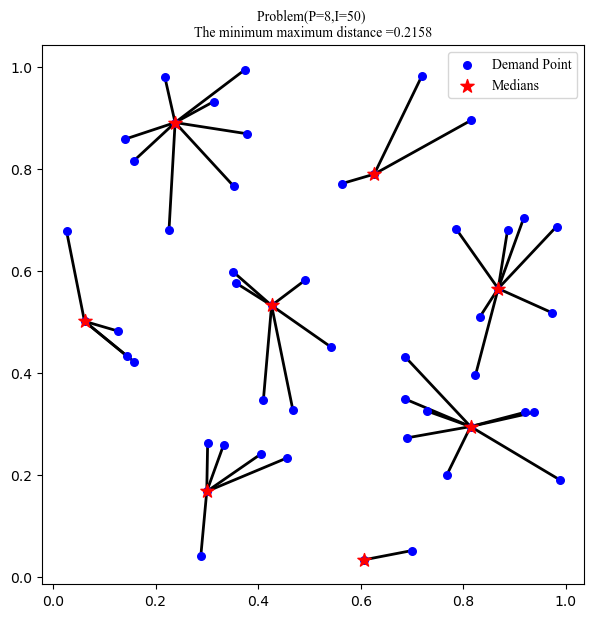

In [6]:
plt.figure(figsize=(7,7))
name = 'Problem(P=' + str(num_located) + ',I=' + str(num_points) + ') \nThe minimum maximum distance =' + str(round(obj,4))
plt.title(name, fontsize = 15,font = 'Times New Roman')

#Points
plt.scatter(*zip(*points_np), c='Blue', marker='o',s=30, label = 'Demand Point', zorder=2)
plt.scatter(*zip(*points_np[centers]), c='Red', marker='*',s=100,label = 'Medians',zorder=3)
#Lines
for i in assigns:
    center_point = points_np[i]
    for j in assigns[i]:
        demand_points = points_np[j]
        pts = [points[i], points[j]]
        plt.plot(*zip(*pts), c='Black', linewidth=2, zorder=1)
# plt.grid(True)   
plt.legend(loc='best',prop='Times New Roman',fontsize=12)
plt.show()

### Case2. Solving p-Center problem with real-world data

Import `geopandas`, `geoplot` to process geographic data and plot map

In [22]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from math import *
from matplotlib.collections import LineCollection

We select Changping District of Beijing the study area and read partial poi points in Tongzhou District.

In [8]:
%%time
region=gpd.read_file("../data/guangzhou/南沙区.shp")
region.head(2)

CPU times: total: 46.9 ms
Wall time: 36.1 ms


,地名,区划码,year,Area,eng,Shape_Leng,Shape_Area,geometry
0,南沙区,440115,2023,661.244108,Nansha,1.841329,0.058095,"MULTIPOLYGON (((113.56252 22.86176, 113.5668 2..."


Partial POI data in Changping district

In [9]:
%%time
poi = gpd.read_file("../data/guangzhou/南沙区_港口码头.shp")

CPU times: total: 0 ns
Wall time: 5 ms


In [10]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Visualization of the input data by geoplot

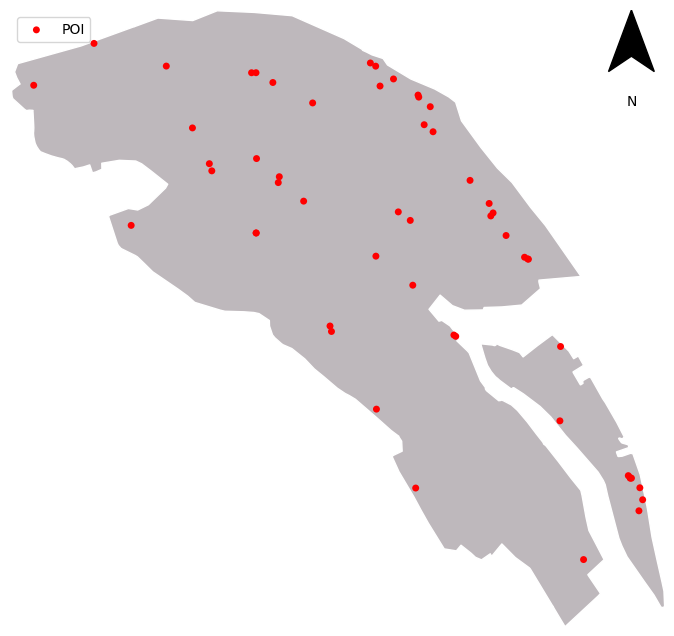

In [11]:
ax = gplt.polyplot(region,
                   projection=gcrs.AlbersEqualArea(),
                   edgecolor="white", facecolor="#BEB8BC",
                   figsize=(10, 8))
gplt.pointplot(poi, 
               extent=region.total_bounds,
               s=5,
               color='red',
               alpha=1,
               linewidth=0,
               label='POI',
               ax=ax)
plt.legend(loc='upper left')
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.05,ratio = 0.7)

Generate problem with real-world data

In [12]:
def get_coordinate(longitude, latitude):
    # lo is the longitude of the location;
    # la is the latitude of the location;

    # coordinate transformation
    R = 6537
    lo = np.mean(longitude)
    la = np.mean(latitude)
    x = R*(longitude-lo)*cos(la)
    y = R*(latitude-la)
    return x,y

In [13]:
data = poi[['lon', 'lat']]
num_points = poi.shape[0]
num_located = 5
x,y=get_coordinate(data['lon'], data['lat'])
pointsxy = [(x[i], y[i]) for i in range(num_points)] # x,y
pointsxy_np = np.array(pointsxy)
points = [(data['lon'][i],data['lat'][i]) for i in range(num_points)] 
points_np = np.array(points)

Output optimal solution

In [14]:
centers, assigns, obj = PCenter(num_points=num_points,
                                points=pointsxy_np,
                                solver=PULP_CBC_CMD(),
                                num_located=num_located).prob_solve()

Status: Optimal
Centers = [5, 15, 25, 29, 34]
Assigned relationships =  {5: [0, 3, 4, 6, 7, 8, 9, 10], 15: [16, 17, 18, 19, 22, 36, 37, 38, 44, 51, 52, 53], 25: [1, 2, 20, 21, 23, 24, 26, 27, 39, 40, 46, 47, 48, 49, 50], 29: [28, 30, 31, 32, 33], 34: [11, 12, 13, 14, 29, 35, 41, 42, 43, 45]}
Minimum Maximum distance =  480.47698


prepare the LineString and center Points to plot the solution

In [15]:
from shapely.geometry import LineString
crs = 'EPSG:4326'
lines = gpd.GeoDataFrame(columns=['id', 'geometry'], crs=crs)
k = 0
for i in assigns:
    center = points_np[i]
    for j in assigns[i]:
        assign = points_np[j]
        line = LineString([center, assign])
        lines.loc[k] = [k+1, line]
        k = k+1
center_points = poi.iloc[centers]

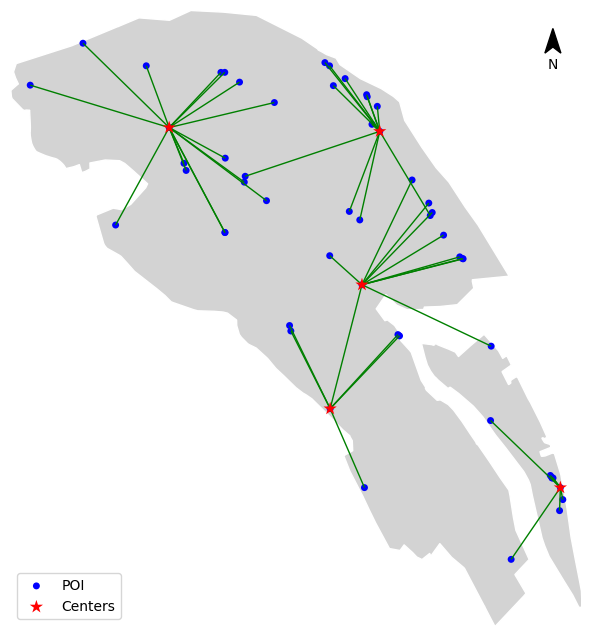

In [16]:
ax = gplt.sankey(lines, 
                 projection=gcrs.Mollweide(),
                 linewidth=1,
                 color='green',
                 zorder=3,
                 figsize=(10, 8),)
gplt.polyplot(region,
              projection=gcrs.AlbersEqualArea(),
              edgecolor="white", 
              facecolor="lightgray",#"#BEB8BC",
              zorder=1,
              ax=ax,)
gplt.pointplot(poi, 
               extent=region.total_bounds,
               s=5,
               color='blue',
               alpha=1,
               linewidth=0,
               label='POI',
               zorder=2,
               ax=ax)
gplt.pointplot(center_points, 
               extent=region.total_bounds,
               s=10,
               color='red',
               alpha=1,
               linewidth=0,
               marker='*',
               label='Centers',
               zorder=4,
               ax=ax)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.02,ratio = 0.7)
plt.legend(loc='lower left')

In [17]:
import math

def render_scale_bar(ax, x=0.05, y=0.05, length_frac=0.15, segments=2,
                     color='black', unit='m', fontsize=9, approx_lat=None, 
                     fixed_max_distance=4000, mode='auto', show_label=False):
    """
    在经纬度坐标图上绘制比例尺。
    - mode: 'true' 强制真实长度；'fixed' 固定长度；'auto' 先尝试真实，失败则固定
    - 刻度固定为 0, 2000, 4000（当 segments=2 且 fixed_max_distance=4000 时）
    """
    is_true = False
    total_m = float(fixed_max_distance)
    try:
        if mode in ('true', 'auto'):
            # 1) 计算该纬度下每1°经度对应的米数
            if approx_lat is None:
                ylim = ax.get_ylim()
                approx_lat = (float(ylim[0]) + float(ylim[1])) / 2.0
            meters_per_deg_lon = 111320.0 * math.cos(math.radians(float(approx_lat)))
            if meters_per_deg_lon <= 0:
                meters_per_deg_lon = 111320.0  # 回退

            # 2) 目标真实长度（米） -> 经度差（度）
            dlon = total_m / meters_per_deg_lon

            # 3) 将经度差换算成 Axes 分数坐标中的长度
            xlim = ax.get_xlim()
            x_span_deg = float(xlim[1]) - float(xlim[0])
            if x_span_deg == 0:
                x_span_deg = 1e-9
            length_frac_true = dlon / x_span_deg

            # 避免过长/过短
            length_frac_true = max(min(length_frac_true, 0.6), 0.05)

            # 4) 主线（真实长度）
            ax.plot([x, x + length_frac_true], [y, y], transform=ax.transAxes, color=color, lw=2)

            # 5) 刻度与数字：等分到 segments 段
            for s in range(segments + 1):
                xs = x + length_frac_true * s / segments
                ax.plot([xs, xs], [y - 0.01, y + 0.01], transform=ax.transAxes, color=color, lw=1)
                val = int(total_m * s / segments)
                ax.text(xs, y - 0.035, f"{val}", ha='center', va='top', transform=ax.transAxes, fontsize=fontsize)

            # 6) 单位 + 模式标签
            unit_text = f"{unit} (true)" if show_label else unit
            ax.text(x + length_frac_true + 0.03, y - 0.035, unit_text, ha='left', va='top',
                    transform=ax.transAxes, fontsize=fontsize)
            is_true = True

        if not is_true and mode == 'true':
            # 需要真实但失败：抛错让外层感知
            raise RuntimeError('True scale computation failed')
    except Exception:
        is_true = False

    if not is_true:
        # 固定长度比例尺（显示相同的0-2000-4000标签，但不保证真实比例）
        ax.plot([x, x + length_frac], [y, y], transform=ax.transAxes, color=color, lw=2)
        for s in range(segments + 1):
            xs = x + length_frac * s / segments
            ax.plot([xs, xs], [y - 0.01, y + 0.01], transform=ax.transAxes, color=color, lw=1)
            val = int(total_m * s / segments)
            ax.text(xs, y - 0.035, f"{val}", ha='center', va='top', transform=ax.transAxes, fontsize=fontsize)
        unit_text = f"{unit} (fixed)" if show_label else unit
        ax.text(x + length_frac + 0.03, y - 0.035, unit_text, ha='left', va='top',
                transform=ax.transAxes, fontsize=fontsize)

    return is_true

In [18]:
# 绘制指北针
def render_north_arrow(ax, x, y, size, ratio = 1):
    # ax： matplotlib的坐标轴对象 绘制指北针
    # x, y： 指北针的左下角坐标
    # size： 指北针的大小
    # ratio： 指北针的比例 默认为1
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2.5, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=22, fontweight='bold')

In [19]:
import os
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib import patheffects as pe

def plot_result_pretty(ls, opt_sites, radius_m=2000, roads_path="data/HuLaTang/Export_Output_2.shp",
                       demand_gridsize=60, demand_cmap="magma", roads_color="#9e9e9e", roads_alpha=0.35,
                       norm_mode="log", vmin_q=0.10, vmax_q=0.995, gamma=0.6, reduce="sum",
                       overlay_points=True, overlay_points_size=6, overlay_points_alpha=0.28,
                       overlay_hex_grid=False, hex_grid_color="#222222", hex_grid_alpha=0.18, hex_grid_lw=0.25,
                       circle_style="ring", show_heat=True, show_colorbar=False, lang="zh", title=None):
    """
    更美观的选址结果绘图：需求热度（hexbin）+ 道路 + 站点 + 服务圈。

    Args:
        ls (GeoDataFrame): 需求点，包含 POINT_X/POINT_Y 或 X/Y 以及 All_pop（可选）。
        opt_sites (DataFrame): 入选站点行，包含 x/y 列（point_x_1/POINT_X...）。
        radius_m (float): 服务半径（与坐标同单位）。
        roads_path (str): 道路 shp 文件路径。
        demand_gridsize (int): 六边形网格大小。
        demand_cmap (str): 需求热度配色。
        roads_color (str): 道路颜色。
        roads_alpha (float): 道路透明度。
        norm_mode (str): 'log' | 'power' | 'linear'。
        vmin_q, vmax_q (float): 需求分位裁剪，仅用于显示。
        gamma (float): PowerNorm 的 gamma。
        reduce (str): 'sum' 或 'mean' 作为 hexbin 聚合方式。
        overlay_points (bool): 是否叠加需求点散点。
        circle_style (str): 'fill' | 'ring' 服务圈样式。
        show_colorbar (bool): 是否显示色标。
        lang (str): 'zh' 或 'en'，控制标签语言。
        title (str|None): 自定义标题。
    """
    # 语言包
    L = {
        'zh': {
            'road': '道路网络', 'demand': '需求点', 'selected': '新建门店', 'current': '现有门店',
            'title': '选址结果与需求强度', 'subtitle': lambda n, r: f"门店数：{n}  半径：{r} m"
        },
        'en': {
            'road': 'Road network', 'demand': 'Demand points', 'selected': 'Selected facilities', 'current': 'Current sites',
            'title': 'Optimized Facilities with Demand Heat', 'subtitle': lambda n, r: f"Facilities: {n}  Radius: {r} m"
        }
    }
    LL = L.get(lang, L['zh'])

    # 1) 需求列与坐标列
    pop_col = None
    if 'speed_pct_freeflow_rev' in ls.columns:
        pop_col = 'speed_pct_freeflow_rev'
    else:
        for c in ls.columns:
            if str(c).lower() == 'all_pop':
                pop_col = c
                break

    # 支持多种坐标列命名：X/Y、POINT_X/POINT_Y、x/y、lon/lat、lng/latitude 等
    def pick_xy_from_ls(df):
        lower_to_orig = {str(c).lower(): c for c in df.columns}
        def choose(candidates):
            for name in candidates:
                if name in lower_to_orig:
                    return lower_to_orig[name]
            return None
        x_col = choose(['x', 'point_x', 'pointx', 'lon', 'lng', 'longitude', 'point_x_1', 'point_x'])
        y_col = choose(['y', 'point_y', 'pointy', 'lat', 'latitude', 'point_y_1', 'point_y'])
        if x_col is None and 'POINT_X' in df.columns:
            x_col = 'POINT_X'
        if y_col is None and 'POINT_Y' in df.columns:
            y_col = 'POINT_Y'
        if x_col is None and 'X' in df.columns:
            x_col = 'X'
        if y_col is None and 'Y' in df.columns:
            y_col = 'Y'
        if x_col is None or y_col is None:
            raise ValueError("ls must contain coordinate columns (X/Y, POINT_X/POINT_Y, or lon/lat).")
        return x_col, y_col

    dx, dy = pick_xy_from_ls(ls)

    # 2) 站点坐标列
    def pick_xy_cols(df):
        x_col = None
        y_col = None
        # 支持更多坐标命名：x/y、X/Y、POINT_X/POINT_Y、lon/lat、lng/latitude
        lower_to_orig = {str(c).lower(): c for c in df.columns}
        def choose(candidates):
            for name in candidates:
                if name in lower_to_orig:
                    return lower_to_orig[name]
            return None
        x_col = choose(['x', 'point_x', 'pointx', 'lon', 'lng', 'longitude', 'point_x_1', 'point_x'])
        y_col = choose(['y', 'point_y', 'pointy', 'lat', 'latitude', 'point_y_1', 'point_y'])
        if x_col is None and 'POINT_X' in df.columns: x_col = 'POINT_X'
        if y_col is None and 'POINT_Y' in df.columns: y_col = 'POINT_Y'
        if x_col is None and 'X' in df.columns: x_col = 'X'
        if y_col is None and 'Y' in df.columns: y_col = 'Y'
        if x_col is None or y_col is None:
            raise ValueError('opt_sites must contain coordinate columns (X/Y, POINT_X/POINT_Y, or lon/lat).')
        return x_col, y_col

    x_col, y_col = pick_xy_cols(opt_sites)

    # 3) 画布
    fig, ax = plt.subplots(figsize=(20, 16))

    # 4) 道路底图
    if isinstance(roads_path, str) and os.path.exists(roads_path):
        try:
            roads = gpd.read_file(roads_path)
            try:
                roads.plot(ax=ax, color=roads_color, linewidth=0.4, alpha=roads_alpha, zorder=1, label=LL['road'])
            except Exception:
                pass
        except Exception:
            pass

    # 5) 需求热度（hexbin），分位裁剪 + 归一
    try:
        if show_heat:
            values = ls[pop_col].to_numpy() if pop_col is not None else None
            if values is not None:
                vmin = float(np.quantile(values, vmin_q)) if 0 <= vmin_q < 1 else None
                vmax = float(np.quantile(values, vmax_q)) if 0 < vmax_q <= 1 else None
                if vmin is not None and vmax is not None and vmax > vmin:
                    values_clipped = np.clip(values, vmin, vmax)
                else:
                    values_clipped = values
                if norm_mode == 'log':
                    from matplotlib.colors import LogNorm
                    norm = LogNorm(vmin=max(values_clipped.min(), 1e-6), vmax=values_clipped.max())
                elif norm_mode == 'power':
                    from matplotlib.colors import PowerNorm
                    norm = PowerNorm(gamma=gamma, vmin=values_clipped.min(), vmax=values_clipped.max())
                else:
                    norm = None
            else:
                values_clipped = None
                norm = None

            reducer = np.sum if reduce == 'sum' else np.mean
            hb = ax.hexbin(ls[dx].to_numpy(), ls[dy].to_numpy(),
                           C=values_clipped,
                           reduce_C_function=reducer if values_clipped is not None else None,
                           gridsize=demand_gridsize, cmap=demand_cmap, bins=None, mincnt=1,
                           linewidths=0, alpha=0.92, zorder=5, norm=norm)
            try:
                hb.set_edgecolor('face')
            except Exception:
                pass
            if show_colorbar and values is not None:
                cbar = fig.colorbar(hb, ax=ax, shrink=0.8)
                cbar.ax.tick_params(labelsize=10)
    except Exception:
        if show_heat:
            sc = ax.scatter(ls[dx], ls[dy], c=ls[pop_col] if pop_col is not None else '#9ecae1',
                            s=8, cmap=demand_cmap, edgecolors='none', zorder=5)
            if show_colorbar and pop_col is not None:
                fig.colorbar(sc, ax=ax, shrink=0.8)

    # 6) 可选叠加：需求点
    if overlay_points:
        try:
            ax.scatter(ls[dx], ls[dy], s=overlay_points_size, c='#2c3e50', alpha=overlay_points_alpha,
                       linewidths=0, zorder=6, label=LL['demand'])
        except Exception:
            pass

    # 7) 门店与服务圈
    legend_flag = {'selected': False, 'current': False}
    for _, row in opt_sites.iterrows():
        cx = float(row[x_col])
        cy = float(row[y_col])
        is_current = ('current' in opt_sites.columns and bool(row['current']) is True)
        if is_current:
            coll = ax.scatter(cx, cy, s=46, marker='o', facecolor='white', edgecolor='red', linewidths=1.2,
                              zorder=10, label=LL['current'] if not legend_flag['current'] else None)
            try:
                coll.set_path_effects([pe.withStroke(linewidth=2.2, foreground='white')])
            except Exception:
                pass
            legend_flag['current'] = True
            circ_kwargs = dict(facecolor='none', edgecolor='red', lw=1.0, alpha=0.9, zorder=9)
            if circle_style == 'fill':
                circ_kwargs.update(facecolor='none')
            ax.add_artist(plt.Circle((cx, cy), radius_m, **circ_kwargs))
        else:
            coll = ax.scatter(cx, cy, s=52, marker='o', facecolor='#FF8C42', edgecolor='white', linewidths=0.8,
                              zorder=11, label=LL['selected'] if not legend_flag['selected'] else None)
            try:
                coll.set_path_effects([pe.withStroke(linewidth=2.0, foreground='white')])
            except Exception:
                pass
            legend_flag['selected'] = True
            if circle_style == 'fill':
                circ = plt.Circle((cx, cy), radius_m, facecolor='#FF8C42', edgecolor='#FF8C42', lw=0.6, alpha=0.12, zorder=8)
            else:
                circ = plt.Circle((cx, cy), radius_m, facecolor='none', edgecolor='#FF8C42', lw=1.2, ls='--', alpha=0.85, zorder=9)
            ax.add_artist(circ)

    # 8) 外观
    ax.axis('scaled')
    ax.tick_params(axis='both', left=False, top=False, right=False,
                   bottom=False, labelleft=False, labeltop=False,
                   labelright=False, labelbottom=False)
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor('#333333')
    ax.margins(x=0.02, y=0.02)

    ttl = title if title is not None else LL['title']
    ax.set_title(ttl + "\n" + LL['subtitle'](len(opt_sites), int(radius_m)), fontsize=18, pad=12)
    try:
        #render_scale_bar(ax=ax, x=0.05, y=0.05)
        #render_scale_bar(ax, x=0.05, y=0.95, length_frac=0.25, segments=2,
                 #color='black', unit='m', fontsize=9, approx_lat=approx_lat, 
                 #fixed_max_distance=4000)
        render_north_arrow(ax=ax, x=0.95, y=0.95, size=0.03, ratio=0.7)
    except Exception:
        pass

    # 9) 图例（统一“Selected facilities / Demand points”大小）
    legend_marker_size = 22         # 放大图例里圆点
    legend_fontsize = 14            # 放大字体
    legend_frame_lw = 2.0           # 框线粗细 
    legend_frame_ec = '#333333'     # 框线颜色
    legend_borderpad = 0.9          # 框与内容的内边距
    legend_labelspacing = 0.8       # 行距
    legend_handlelength = 1.6       # 句柄长度
    legend_handletextpad = 0.8      # 句柄与文字间距
    has_current = ('current' in opt_sites.columns and bool(np.any(opt_sites['current'].astype(bool))))
    custom_handles = []
    # road
    #custom_handles.append(Line2D([0], [0], color=roads_color, lw=1.0, alpha=0.6, label=LL['road']))
    # current (optional)
    if has_current:
        custom_handles.append(Line2D([0], [0], marker='o', color='none', markerfacecolor='white',
                                    markeredgecolor='red', markeredgewidth=1.2, markersize=legend_marker_size,
                                     label=LL['current']))
    # demand
    if overlay_points:
        custom_handles.append(Line2D([0], [0], marker='o', color='none', markerfacecolor='#2c3e50',
                                     markersize=legend_marker_size, alpha=overlay_points_alpha, label=LL['demand']))
    # selected
    if len(opt_sites) > 0:
        custom_handles.append(Line2D([0], [0], marker='o', color='none', markerfacecolor='#FF8C42',
                                     markeredgecolor='white', markeredgewidth=0.8, markersize=legend_marker_size,
                                     label=LL['selected']))
    leg = ax.legend(handles=custom_handles, loc='lower left', markerscale=1.0, frameon=True, framealpha=0.85, fontsize=20)

    # 强化框线 
    leg.get_frame().set_linewidth(legend_frame_lw)
    leg.get_frame().set_edgecolor(legend_frame_ec)
    fig.tight_layout()
    return ax


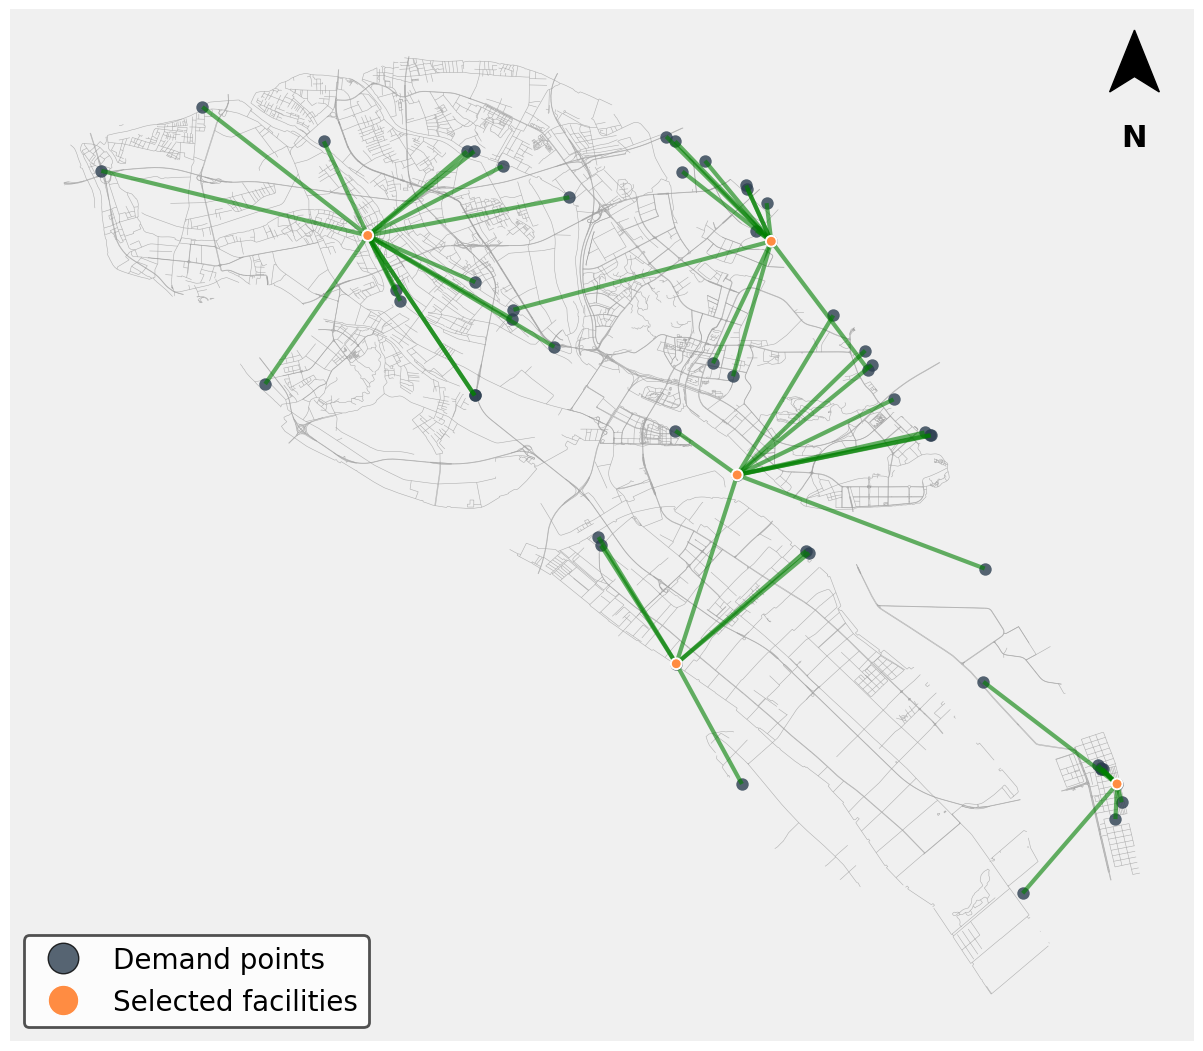

In [29]:
# Demo call for pretty plot (Gurobi)
#try:
#    opt_sites = cand_df.loc[selected_sites]
#except Exception:
#    opt_sites = cand_df.iloc[:30]
ls = poi[['lon','lat']].copy()

# 估计中心纬度用于换算（经纬度数据时）
approx_lat = float(ls['lat'].mean()) if 'lat' in ls.columns else float(ls['Y'].mean())

ax = plot_result_pretty(
    #ls_hlt,
    ls,
    center_points,
    radius_m=550,
    roads_path="D:\Academic\Task123_HiSpot\hispot-main\data\guangzhou\南沙区路网.shp",
    demand_gridsize=80,
    demand_cmap="inferno",
    roads_color="#9e9e9e", roads_alpha=0.8,
    overlay_points_size=80, overlay_points_alpha=0.8,
    norm_mode="log",
    vmin_q=0.12,
    vmax_q=0.995,
    reduce="sum",
    circle_style="ring",
    show_heat=False,
    #show_heat=True,
    lang="en",
    title="pCenter-Optimized Facilities"
)
# 16:9 canvas (for PPT) and save HD image


fig = ax.figure
fig.set_size_inches(20, 11.25)
fig.tight_layout()
ax.set_title('')
for s in ax.spines.values(): s.set_visible(False)
ax.set_xticks([]); ax.set_yticks([])
#ax.set_title("pCenter-Optimized Facilities\nCenters: 5", fontsize=18, pad=12)
ax.set_facecolor("#F0F0F0")      # 改坐标区底色
#ax.figure.patch.set_facecolor("#CDAD00")  # 可选：改整张图画布底色

#fig.savefig("pCenter-nansha.png", dpi=300, facecolor=fig.get_facecolor())

segments = [np.array([points_np[ci], points_np[dj]]) for ci, js in assigns.items() for dj in js]
lc = LineCollection(segments, colors='green', linewidths=3, alpha=0.6, zorder=10)
ax.add_collection(lc)

fig.savefig("pCenter-nansha.png", dpi=300, bbox_inches="tight")
plt.show()


In [63]:
# 在含三张图片的目录或 Notebooks 目录运行
# 倒立“品”字形：上排两张（右 MCLP，左 BCLP），下排一张（LSCP 居中）
# 每张图片下方标注：(a) (b) (c)；不缩放原图，300 DPI 保存

from pathlib import Path

try:
    from PIL import Image, ImageDraw, ImageFont
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pillow"])
    from PIL import Image, ImageDraw, ImageFont

# 1) 定位图片
name_map = {
    "p-Center": "pCenter-nansha.png",
    "p-Median": "pMedian-nansha.png",
    "p-Hub": "pHub-nansha.png",
}
cwd = Path.cwd()
roots = [cwd, cwd / "Notebooks"]
paths = None
for root in roots:
    cand = {k: root / v for k, v in name_map.items()}
    if all(p.exists() for p in cand.values()):
        paths = cand
        break
if paths is None:
    missing = [str((roots[0] / v)) for v in name_map.values()]
    raise FileNotFoundError("找不到三张图片，请确认当前目录或 Notebooks 目录下存在：\n" + "\n".join(missing))

# 2) 打开图片（保留原始像素）
img_m = Image.open(paths["p-Center"]).convert("RGB")  # 右上
img_b = Image.open(paths["p-Median"]).convert("RGB")  # 左上
img_l = Image.open(paths["p-Hub"]).convert("RGB")  # 下方

# 3) 版式参数
outer_margin = 40         # 画布四周边距
h_gap = 40                # 上排两图的水平间距
v_gap = 50                # 上排与下排的垂直间距
bg_color = (255, 255, 255)
text_color = (0, 0, 0)

# 4) 字体与标注
def load_font(font_size: int) -> ImageFont.FreeTypeFont | ImageFont.ImageFont:
    candidates = [
        r"C:\Windows\Fonts\msyh.ttc",
        r"C:\Windows\Fonts\SimHei.ttf",
        r"C:\Windows\Fonts\simsun.ttc",
        r"C:\Windows\Fonts\arial.ttf",
    ]
    for fp in candidates:
        if Path(fp).exists():
            try:
                return ImageFont.truetype(fp, font_size)
            except Exception:
                pass
    return ImageFont.load_default()

base_width = min(img_m.width, img_b.width, img_l.width)
font_size = max(24, min(72, int(round(base_width * 0.05))))
font = load_font(font_size)
label_margin_top = max(10, int(round(font_size * 0.4)))

# 使用 ASCII 括号以保证兼容性
labels = {
    "p-Center": "(a) p-Center",
    "p-Median": "(b) p-Median",
    "p-Hub": "(c) p-Hub",
}

# 5) 计算画布尺寸（倒立“品”）
top_row_width = img_b.width + h_gap + img_m.width
inner_width = max(top_row_width, img_l.width)
top_row_height = max(img_b.height, img_m.height)

# 行高 = 图片最大高 + 文本行高（用 font_size 近似）
inner_height = (
    top_row_height + label_margin_top + font_size +  # 上排图与其标注
    v_gap +
    img_l.height + label_margin_top + font_size      # 下排图与其标注
)
canvas_w = inner_width + 2 * outer_margin
canvas_h = inner_height + 2 * outer_margin
canvas = Image.new("RGB", (canvas_w, canvas_h), bg_color)
draw = ImageDraw.Draw(canvas)

# 6) 上排摆放（左：BCLP，右：MCLP），整体水平居中
top_y = outer_margin
top_x_left = outer_margin + (inner_width - top_row_width) // 2
top_x_right = top_x_left + img_b.width + h_gap
canvas.paste(img_b, (top_x_left, top_y))
canvas.paste(img_m, (top_x_right, top_y))

# 上排标注统一基线
top_label_y = top_y + top_row_height + label_margin_top
for (img, x), key in [((img_b, top_x_left), "p-Median"), ((img_m, top_x_right), "p-Center")]:
    text = labels[key]
    tb = draw.textbbox((0, 0), text, font=font)
    tw = tb[2] - tb[0]
    tx = x + (img.width - tw) // 2
    draw.text((tx, top_label_y), text, fill=text_color, font=font)

# 7) 下排摆放（LSCP 居中）
bottom_y = top_label_y + font_size + v_gap
bottom_x = outer_margin + (inner_width - img_l.width) // 2
canvas.paste(img_l, (bottom_x, bottom_y))

# 下排标注
bottom_label_y = bottom_y + img_l.height + label_margin_top
text = labels["p-Hub"]
tb = draw.textbbox((0, 0), text, font=font)
tw = tb[2] - tb[0]
tx = bottom_x + (img_l.width - tw) // 2
draw.text((tx, bottom_label_y), text, fill=text_color, font=font)

# 8) 保存
out_path = cwd / "combined_nansha_pin_inverted.png"
canvas.save(out_path, dpi=(300, 300))
print(f"已生成：{out_path.resolve()}  尺寸：{canvas_w}x{canvas_h}px，DPI: 300")

已生成：D:\Academic\Task123_HiSpot\hispot-main\Notebooks\combined_nansha_pin_inverted.png  尺寸：7340x6640px，DPI: 300


In [72]:
# 合并两张路径图：将 pCenter 与 pMedian 的“paths”图左右拼接为一张，并在下方添加图注
# - 自动尝试导入 Pillow，若未安装会自动安装
# - 在当前目录或 Notebooks 目录查找图片
# - 不缩放原图，高度按较大者对齐并垂直居中
# - 输出：combined_nansha_paths.png（300DPI）
from pathlib import Path

try:
    from PIL import Image, ImageDraw, ImageFont
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pillow", "-q"])
    from PIL import Image, ImageDraw, ImageFont

# 定义文件名（左/右）
left_name = "pCenter-nansha-paths.png"   # 左侧
right_name = "pMedian-nansha-paths.png"  # 右侧

# 在当前目录与 Notebooks 目录尝试定位
cwd = Path.cwd()
p1 = cwd / left_name
p2 = cwd / right_name
if not (p1.exists() and p2.exists()):
    alt = cwd / "Notebooks"
    p1_alt = alt / left_name
    p2_alt = alt / right_name
    if p1_alt.exists() and p2_alt.exists():
        p1, p2 = p1_alt, p2_alt
    else:
        missing = []
        for pp in [p1, p2, p1_alt, p2_alt]:
            if not pp.exists():
                missing.append(str(pp))
        raise FileNotFoundError("未找到图片文件，请确认存在以下任一位置：\n" + "\n".join(set(missing)))

# 打开图片并转为 RGB
img_left = Image.open(p1).convert("RGB")
img_right = Image.open(p2).convert("RGB")

# -------- 字体与图注设置 --------
def load_font(font_size: int):
    candidates = [
        r"C:\\Windows\\Fonts\\msyh.ttc",
        r"C:\\Windows\\Fonts\\SimHei.ttf",
        r"C:\\Windows\\Fonts\\simsun.ttc",
        r"C:\\Windows\\Fonts\\arial.ttf",
    ]
    for fp in candidates:
        if Path(fp).exists():
            try:
                return ImageFont.truetype(fp, font_size)
            except Exception:
                pass
    return ImageFont.load_default()

base_width = min(img_left.width, img_right.width)
font_size = max(22, min(80, int(round(base_width * 0.05))))
font = load_font(font_size)
# 将图注整体上移一些，同时在底部增加缓冲，避免被裁切
label_margin_top = max(8, int(round(font_size * 0.25)))
label_bottom_pad = max(8, int(round(font_size * 0.18)))
left_label = "(a) p-Center"
right_label = "(b) p-Median"

# 先用临时画布测量文本高度
_tmp = Image.new("RGB", (10, 10), (255, 255, 255))
_tmp_draw = ImageDraw.Draw(_tmp)
left_bbox = _tmp_draw.textbbox((0, 0), left_label, font=font)
right_bbox = _tmp_draw.textbbox((0, 0), right_label, font=font)
text_h = max(left_bbox[3] - left_bbox[1], right_bbox[3] - right_bbox[1])

# -------- 画布尺寸（不缩放） --------
gap = 30  # 两图之间留白
H_img = max(img_left.height, img_right.height)
H = H_img + label_margin_top + text_h + label_bottom_pad
W = img_left.width + gap + img_right.width
canvas = Image.new("RGB", (W, H), (255, 255, 255))

# 垂直居中粘贴两张图
y1 = (H_img - img_left.height) // 2
y2 = (H_img - img_right.height) // 2
canvas.paste(img_left, (0, y1))
canvas.paste(img_right, (img_left.width + gap, y2))

# -------- 绘制图注（下方居中） --------
draw = ImageDraw.Draw(canvas)
# 左图注
lb = draw.textbbox((0, 0), left_label, font=font)
ltw = lb[2] - lb[0]
left_x0 = (img_left.width - ltw) // 2
left_y0 = H_img + label_margin_top
# 右图注
rb = draw.textbbox((0, 0), right_label, font=font)
rtw = rb[2] - rb[0]
right_start_x = img_left.width + gap
right_x0 = right_start_x + (img_right.width - rtw) // 2
right_y0 = H_img + label_margin_top
# 绘制文本
text_color = (0, 0, 0)
draw.text((left_x0, left_y0), left_label, fill=text_color, font=font)
draw.text((right_x0, right_y0), right_label, fill=text_color, font=font)

# 保存输出
out_path = cwd / "combined_nansha_paths.png"
canvas.save(out_path, dpi=(300, 300))
print(f"已生成: {out_path.resolve()}  尺寸: {W}x{H}px, DPI: 300")


已生成: D:\Academic\Task123_HiSpot\hispot-main\Notebooks\combined_nansha_paths.png  尺寸: 3868x1888px, DPI: 300
